In [1]:
%run setup.ipynb

In [2]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# PR2_1 SLIDESHOW

**Assessing Lombardia Pollutant data with Clustering techniques**   
The projects aim at analyzing pollutant data related to the Lombardia region.


## Uploading and Data Exploration

In [3]:
import os
folder_path = f'{DATA_PATH}'
all_files = os.listdir(folder_path)
dataframes = {}
# Iterating through all the files
for file in all_files:
    if file.endswith(".csv"):
        file_path = os.path.join(folder_path, file)
        # Loading the CSV and saving it to the dictionary
        current_df = pd.read_csv(file_path, encoding = "latin-1", header = [0,1])
        dataframes[file] = current_df

We create the dataset by concatenating all the files.
Then we exclude the year 2017 beacuse we had just missing values on the pollutants variables.

In [4]:
combined_df = pd.DataFrame()
lista = ['012','013','014','015','016','017','018','019','020','097','098','108']
for i in range(len(lista)):
    df_1 = dataframes[f'03_{lista[i]}_2017-2020.csv']
    df_2 = dataframes[f'03_{lista[i]}_2021.csv']
    concat_df = pd.concat([df_1, df_2], axis=0, ignore_index=True)
    combined_df = pd.concat([combined_df, concat_df], axis = 0, ignore_index=True)
    combined_df = combined_df.loc[combined_df['DATE']['YYYY'] != 2017]  

In [5]:
combined_df = combined_df.reset_index(drop=True)

In [6]:
print(combined_df.shape)
combined_df.head()

(15696, 123)


DATE ---    PROV  ---            MET   ---                ...  \
   YYYY  MM DD  COM   GP   A[km2]    TG    TN     TX     HU  ...   
0  2018   1  1  138  552  1199.24  2.67  1.28   3.94  87.43  ...   
1  2018   1  2  138  552  1199.24  5.29 -0.56  12.02  58.93  ...   
2  2018   1  3  138  552  1199.24  3.87 -0.18   8.68  70.64  ...   
3  2018   1  4  138  552  1199.24  5.80  1.94   9.96  83.85  ...   
4  2018   1  5  138  552  1199.24  3.02 -0.03   5.97  90.65  ...   

                  SO2    125  ug.m-3   24h     ---                 >TS  \
                   Av Median StDev.5 Max.2 COMx.11 Min.11 COMn.11 GP.9   
0                2.77   2.74     0.6   6.4    1474   0.32    1449    0   
1                1.82   1.79    0.38  5.01    1474   0.33    1449    0   
2                1.02     1.    0.21  4.35    1577   0.18    1516    0   
3                0.99   0.97    0.24  4.22    1474   0.18    1516    0   
4  2.5500000000000003   2.52    0.59   6.8    1474   0.34    1449    0   

        ---         
  A[km2].10 A[%].9  
0        0.     0.  
1        0.     0.  
2        0.     0.  
3        0.     0.  
4        0.     0.  

[5 rows x 123 columns]

In [7]:
for colonna in combined_df.columns:
    combined_df[colonna] = pd.to_numeric(combined_df[colonna], errors='coerce')

In [8]:
combined_df['DATA'] = combined_df.iloc[:,0].astype(str) + '-' + combined_df.iloc[:,1].astype(str) + '-' + combined_df.iloc[:,2].astype(str)

C:\Users\pierd\AppData\Local\Temp\ipykernel_9464\1592434521.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['DATA'] = combined_df.iloc[:,0].astype(str) + '-' + combined_df.iloc[:,1].astype(str) + '-' + combined_df.iloc[:,2].astype(str)


In [9]:
combined_df['DATA']=pd.to_datetime(combined_df['DATA'])

In [10]:
combined_df.head()

DATE ---    PROV  ---            MET   ---                ...    125  \
   YYYY  MM DD  COM   GP   A[km2]    TG    TN     TX     HU  ... Median   
0  2018   1  1  138  552  1199.24  2.67  1.28   3.94  87.43  ...   2.74   
1  2018   1  2  138  552  1199.24  5.29 -0.56  12.02  58.93  ...   1.79   
2  2018   1  3  138  552  1199.24  3.87 -0.18   8.68  70.64  ...   1.00   
3  2018   1  4  138  552  1199.24  5.80  1.94   9.96  83.85  ...   0.97   
4  2018   1  5  138  552  1199.24  3.02 -0.03   5.97  90.65  ...   2.52   

   ug.m-3   24h     ---                 >TS       ---              DATA  
  StDev.5 Max.2 COMx.11 Min.11 COMn.11 GP.9 A[km2].10 A[%].9             
0    0.60  6.40  1474.0   0.32  1449.0  0.0       0.0    0.0 2018-01-01  
1    0.38  5.01  1474.0   0.33  1449.0  0.0       0.0    0.0 2018-01-02  
2    0.21  4.35  1577.0   0.18  1516.0  0.0       0.0    0.0 2018-01-03  
3    0.24  4.22  1474.0   0.18  1516.0  0.0       0.0    0.0 2018-01-04  
4    0.59  6.80  1474.0   0.34  1449.0  0.0       0.0    0.0 2018-01-05  

[5 rows x 124 columns]

### DATASET DESCRIPTION

We have time series data for the 12 provinces of Lombardia, a region in the north of Italy. The daily surveys goes from 1st January 2018 to 31 July 2021   
(365 + 365 + 366 + 212 = 1308 days). In total there are **1308 rows for each province**. On the 29-02-2020 and on the 29/30/31 December 2020 days we have no data for pollutants variables. In the dataset there are variables related to the weather, but we will not use them for our analysis. The dataset has two headers: on the 1st we have the general info like DATE, PROVINCE, AQI_1, and all the pollutant variables, and on the 2nd we have the syntex measures like Mean, Median, Max, Min, StDeviation.

#### Variable description

AQI_1: Air Quality Index surveys. For each day are showed Average, StDeviation, Max, Min, Median, Comx, Comn.

The unit of measure of every pollutant is micrograms on cubic meter.

- CO: Carbon monoxide   
- NH3: Ammonia   
- NMVOC: Non-methane volatile organic compound   
- NO2: Nitrogen dioxide   
- NO: Nitrogen monoxide   
- O3: Ozone   
- PANS: Perchlorate acids   
- PM10: Atmosphere particulate Matter with a diameter of 10 micrometer or less   
- PM2.5: Atmosphere particulate Matter with a diameter of 2.5 micrometer or less   
- SO2: Sulfur dioxide   

AQI_2: an other Air Quality Index survey.

## 1st Research Question

**What are the most effective clustering techniques for analyzing the patterns of 10 pollutants across the 12 Lombardia's provinces, and how do these techniques contribute to the identification of distinct pollution profiles and regional similarities?**

In [11]:
df = pd.read_csv(f'{RESULTS_PATH}/combined_df.csv', header=[0,1])

In [12]:
df.columns = df.columns.droplevel(1)
df.head()

,DATE,---,---,PROV,---,---,MET,---,---,---,...,125,ug.m-3,24h,---,---,---,>TS,---,---,DATA
0,2018,1,1,138,552,1199.24,2.67,1.28,3.94,87.43,...,2.74,0.60,6.40,1474.0,0.32,1449.0,0.0,0.0,0.0,2018-01-01
1,2018,1,2,138,552,1199.24,5.29,-0.56,12.02,58.93,...,1.79,0.38,5.01,1474.0,0.33,1449.0,0.0,0.0,0.0,2018-01-02
2,2018,1,3,138,552,1199.24,3.87,-0.18,8.68,70.64,...,1.00,0.21,4.35,1577.0,0.18,1516.0,0.0,0.0,0.0,2018-01-03
3,2018,1,4,138,552,1199.24,5.80,1.94,9.96,83.85,...,0.97,0.24,4.22,1474.0,0.18,1516.0,0.0,0.0,0.0,2018-01-04
4,2018,1,5,138,552,1199.24,3.02,-0.03,5.97,90.65,...,2.52,0.59,6.80,1474.0,0.34,1449.0,0.0,0.0,0.0,2018-01-05


In [13]:
df = df.apply(pd.to_numeric, errors='coerce')

We have generated a dataset of size 12 x 10, where each row corresponds to a province, and the values represent the means (of the whole period 2018-21) of the pollutants daily surveys.

In [14]:
colonnes_da_media = ['CO', 'NH3', 'NMVOC', 'NO2', 'NO', 'O3', 'PANS', 'PM10', 'PM2.5', 'SO2']
X = df.groupby('PROV')[colonnes_da_media].mean().reset_index()

In [15]:
mappa_province = {
    55: 'Monza', #108
    60: 'Lodi', #098
    64: 'Mantova', #020
    77: 'Sondrio', #014
    84: 'Lecco', #097
    113: 'Cremona', #019
    133: 'Milano', #015
    138: 'Varese', #012
    148: 'Como', #013
    186: 'Pavia', #018
    205: 'Brescia', #017
    243: 'Bergamo',  #016
}

X['PROV'] = X['PROV'].map(mappa_province)

In [16]:
X.set_index('PROV', inplace=True)
X

,CO,NH3,NMVOC,NO2,NO,O3,PANS,PM10,PM2.5,SO2
PROV,,,,,,,,,,
Monza,433.236311,7.563474,104.507140,48.490660,20.900683,75.389716,3.676702,29.660314,25.418328,3.193344
Lodi,332.017301,18.792469,57.355054,31.512163,8.461419,78.932247,3.024923,27.951235,23.707814,1.792439
Mantova,293.995322,24.006396,44.128367,24.297002,5.195069,79.781212,2.863014,28.252891,23.509701,1.642255
Sondrio,164.472891,1.109862,10.873919,2.300199,5.394709,77.098113,2.563919,9.605544,7.617891,0.278267
Lecco,297.334172,3.150660,44.940974,24.566158,5.131948,81.711396,3.532776,20.692255,17.576258,1.348765
Cremona,322.867699,25.380675,53.398190,28.677201,6.976572,78.903405,2.972048,29.071910,24.571833,1.650230
Milano,406.308712,10.069862,95.749885,22.007883,40.394317,76.469732,3.362247,29.278313,24.994877,3.473252
Varese,315.201610,3.725245,55.594486,9.860828,25.578129,79.432630,3.498627,21.917132,18.479486,1.862784
Como,292.748704,2.972477,46.301541,8.121304,21.664778,81.655690,3.479693,20.325867,17.096227,1.449793


### DESCRIPTIVE ANALYSIS
### Pollutant Barplots

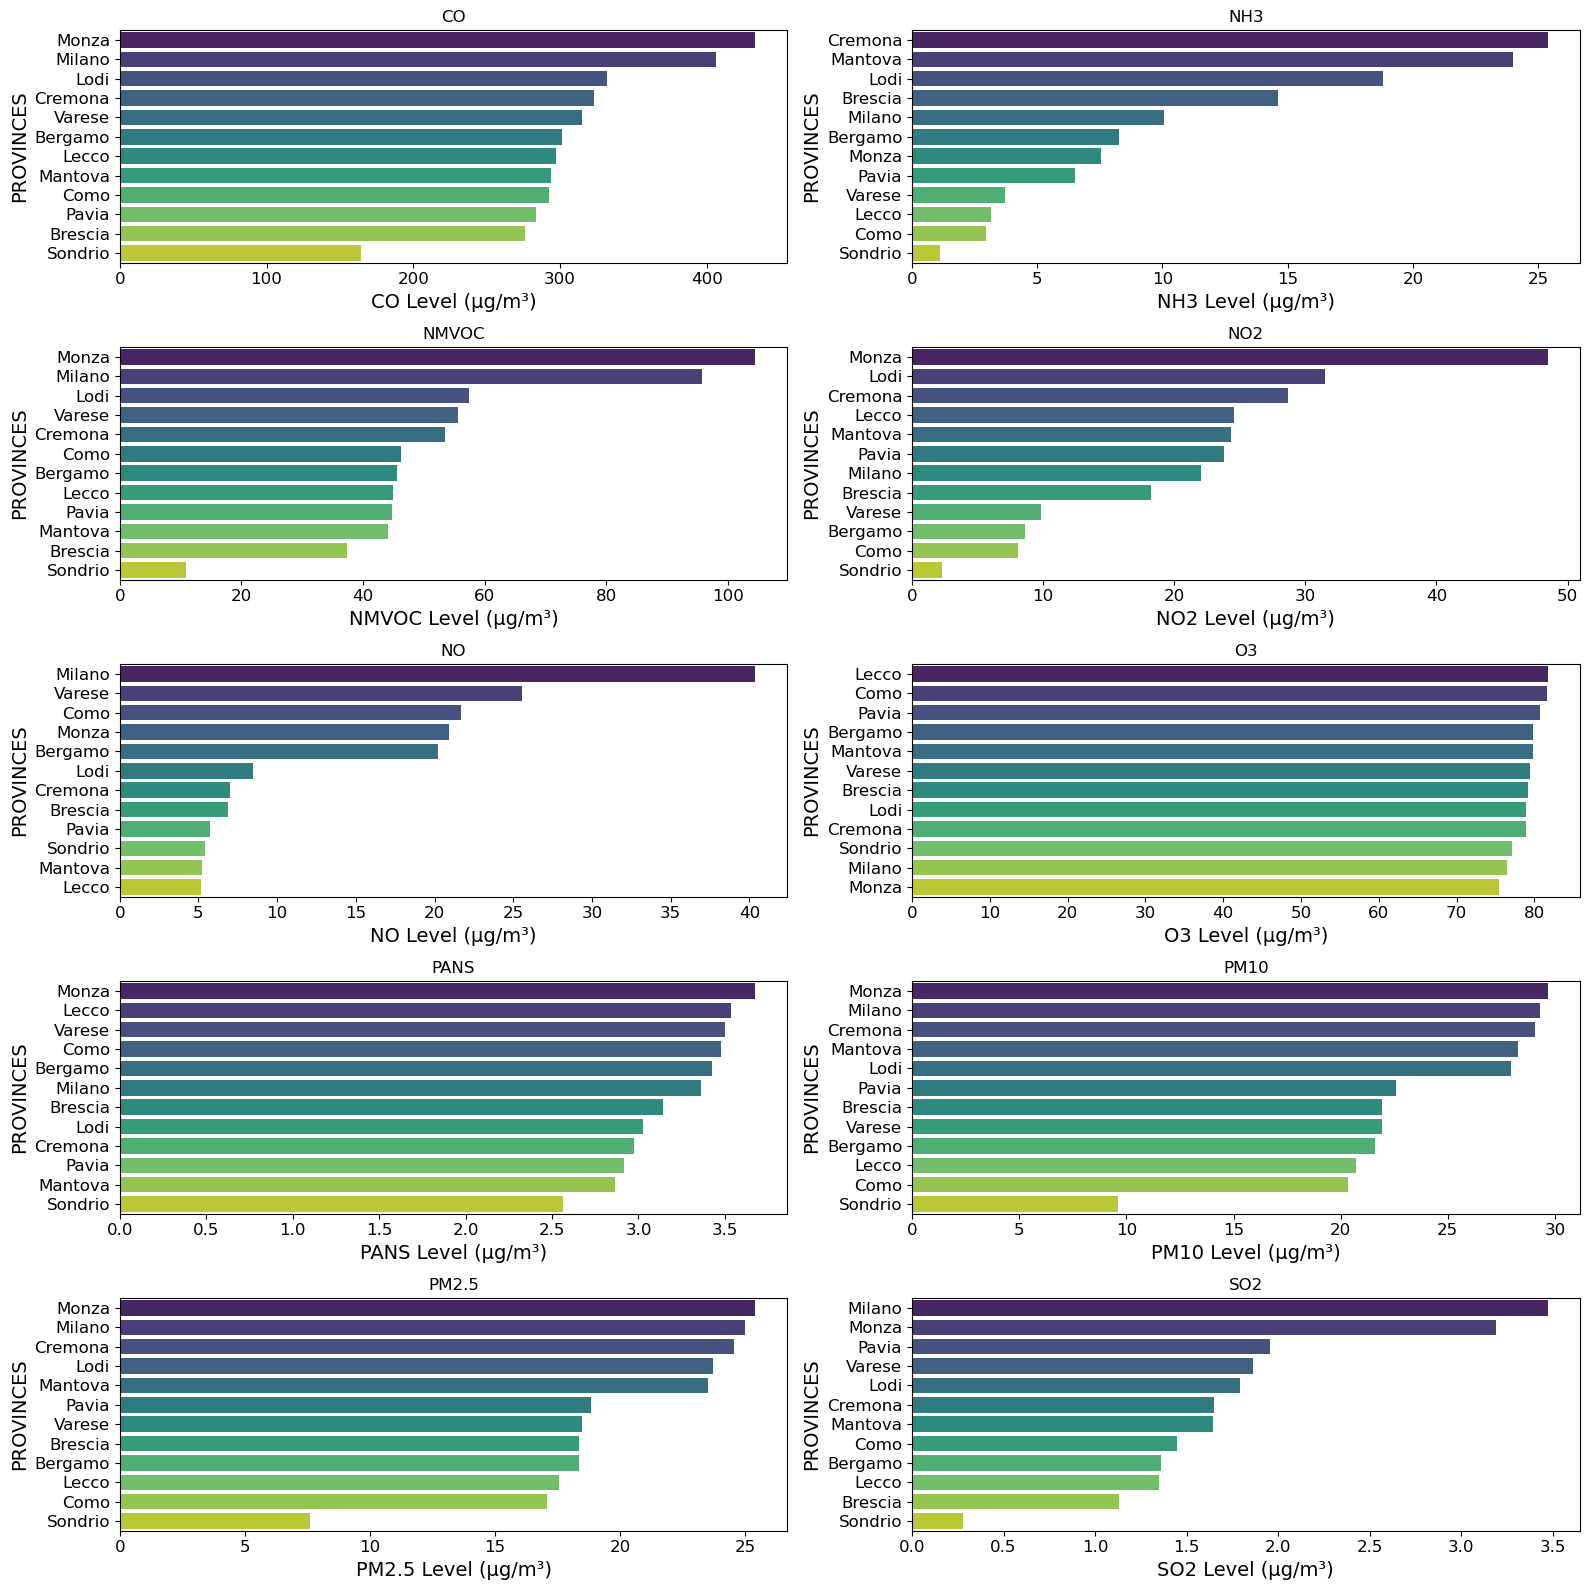

In [17]:
fig = plt.figure(figsize=(16, 16))
# iterating through the pollutant variables (columns)
for j, column in enumerate(X.columns):
    # subplots 
    plt.subplot(5, 2, j+1)
    plt.title(column, fontsize=12)
    top = X.groupby(X.index)[column].max().sort_values(ascending=False)
    sns.barplot(x=top.values, y=top.index, palette="viridis")
    plt.xlabel(f"{column} Level (µg/m³)")
    plt.ylabel("PROVINCES")

# spaces between subplots
plt.tight_layout()
#plt.savefig(f'{IMAGES_PATH}/Pollutant_Barplots.png')
plt.show()

In general, Monza and Milano are the most polluted provinces while Sondrio is the least.   
Ozone (O3) and PANS are the least discriminant pollutants.   
We can notice also that NH3 differs from other pollutants, in fact for this pollutant the highest values are for provinces of Cremona, Mantova and Lodi.
For the nitrogen oxydes (NOx) Monza has the highest value for NO2, while Milano for NO.

### 1.1 - HIERARCHICAL AGGLOMERATIVE CLUSTERING

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

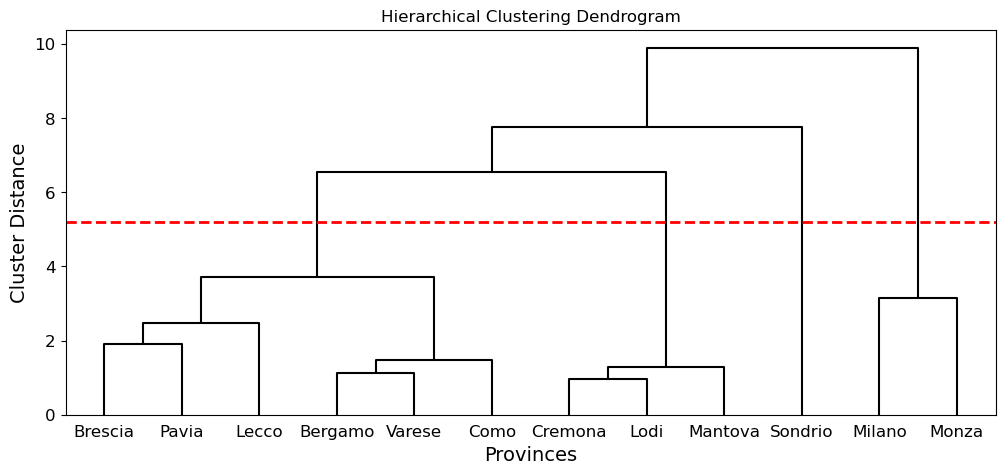

In [19]:
# Plot dendrogram to decide how many cluster we have to select
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, labels=X.index, link_color_func=lambda x: 'k')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Provinces')
plt.ylabel('Cluster Distance')
plt.axhline(y=5.2, color='red', linestyle='--', linewidth=2)
plt.savefig(f'{IMAGES_PATH}/Dendogram.png')
plt.show()

**We slice the dendogram evaluating the aggregation among clusters that are very distant. The higher the branch, the higher the distance between clusters.**

In [20]:
# Agglomerative clustering for 4 groups
agg_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_labels = agg_clustering.fit_predict(X_scaled)

In [21]:
X_agg = X.copy()
X_agg['labels'] = agg_labels

In [22]:
from tabulate import tabulate
table1 = [['Clusters', 'Provinces'],
          ['0', 'Mantova, ' 'Lodi, ' 'Cremona'],
          ['1', 'Lecco, ' 'Varese, ' 'Como, ''Pavia, ''Brescia, ''Bergamo' ],
          ['2', 'Milano, ' 'Monza'],
          ['3', 'Sondrio']]
print(tabulate(table1, headers='firstrow', tablefmt='fancy_grid'))

╒════════════╤══════════════════════════════════════════════╕
│   Clusters │ Provinces                                    │
╞════════════╪══════════════════════════════════════════════╡
│          0 │ Mantova, Lodi, Cremona                       │
├────────────┼──────────────────────────────────────────────┤
│          1 │ Lecco, Varese, Como, Pavia, Brescia, Bergamo │
├────────────┼──────────────────────────────────────────────┤
│          2 │ Milano, Monza                                │
├────────────┼──────────────────────────────────────────────┤
│          3 │ Sondrio                                      │
╘════════════╧══════════════════════════════════════════════╛


### 1.2 - KMEANS

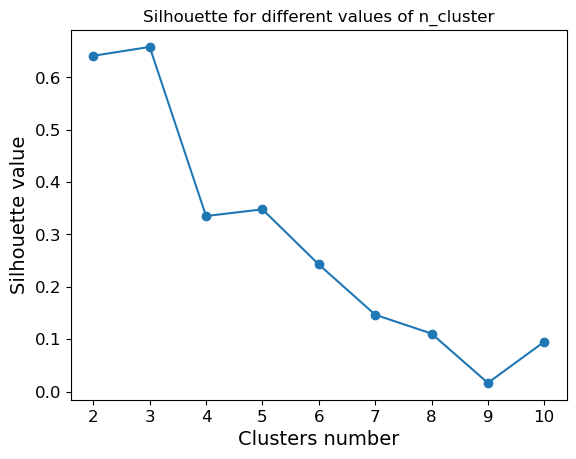

In [23]:
silhouette_scores = []
n_clusters_range = range(2, 11)
for n_cluster in n_clusters_range:   
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)     
    kmeans.fit(X_scaled)
    silhouette_coefficient = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette_coefficient)

plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.xlabel('Clusters number')
plt.ylabel('Silhouette value')
plt.title('Silhouette for different values of n_cluster')
plt.show()

In [24]:
wss = []
for i in range(1,11):
    cluster = KMeans(n_clusters=i,init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)
    cluster.fit(X_scaled)
    wss.append(cluster.inertia_)

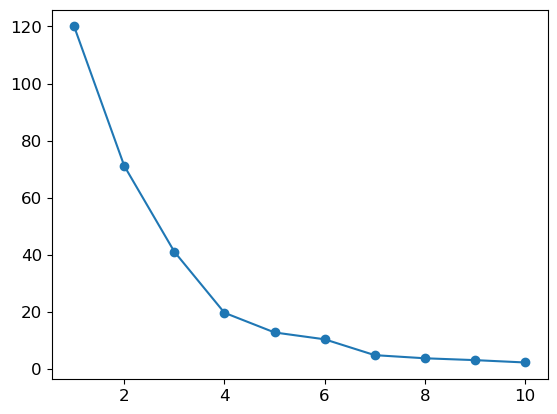

In [25]:
plt.plot(range(1,11),wss,marker ='o')
plt.show()

**We choose 4 clusters**

In [26]:
cluster_final = KMeans(n_clusters=4, random_state=2)
pred = cluster_final.fit_predict(X_scaled)
X_km = X.copy()
X_km['labels'] = pred

In [27]:
X_km[X_km['labels'] == 0]

,CO,NH3,NMVOC,NO2,NO,O3,PANS,PM10,PM2.5,SO2,labels
PROV,,,,,,,,,,,
Lodi,332.017301,18.792469,57.355054,31.512163,8.461419,78.932247,3.024923,27.951235,23.707814,1.792439,0
Mantova,293.995322,24.006396,44.128367,24.297002,5.195069,79.781212,2.863014,28.252891,23.509701,1.642255,0
Cremona,322.867699,25.380675,53.398190,28.677201,6.976572,78.903405,2.972048,29.071910,24.571833,1.650230,0


In [28]:
X_km[X_km['labels'] == 1]

,CO,NH3,NMVOC,NO2,NO,O3,PANS,PM10,PM2.5,SO2,labels
PROV,,,,,,,,,,,
Lecco,297.334172,3.150660,44.940974,24.566158,5.131948,81.711396,3.532776,20.692255,17.576258,1.348765,1
Varese,315.201610,3.725245,55.594486,9.860828,25.578129,79.432630,3.498627,21.917132,18.479486,1.862784,1
Como,292.748704,2.972477,46.301541,8.121304,21.664778,81.655690,3.479693,20.325867,17.096227,1.449793,1
Pavia,283.833374,6.526196,44.738121,23.826940,5.755038,80.740084,2.915821,22.595215,18.823620,1.956741,1
Brescia,275.868520,14.613290,37.412262,18.230859,6.877538,79.174126,3.140521,21.938758,18.360690,1.128167,1
Bergamo,301.711281,8.262324,45.506143,8.622592,20.197837,79.785706,3.423474,21.610874,18.352960,1.360844,1


In [29]:
X_km[X_km['labels'] == 2]  

,CO,NH3,NMVOC,NO2,NO,O3,PANS,PM10,PM2.5,SO2,labels
PROV,,,,,,,,,,,
Monza,433.236311,7.563474,104.507140,48.490660,20.900683,75.389716,3.676702,29.660314,25.418328,3.193344,2
Milano,406.308712,10.069862,95.749885,22.007883,40.394317,76.469732,3.362247,29.278313,24.994877,3.473252,2


In [30]:
X_km[X_km['labels'] == 3]  

,CO,NH3,NMVOC,NO2,NO,O3,PANS,PM10,PM2.5,SO2,labels
PROV,,,,,,,,,,,
Sondrio,164.472891,1.109862,10.873919,2.300199,5.394709,77.098113,2.563919,9.605544,7.617891,0.278267,3


In [31]:
cluster_means = X_km.groupby('labels').mean()

In [32]:
data_tab = {
    'CO': [316.293441, 294.449610, 419.772512, 164.472891],
    'NH3': [22.726513, 6.541699, 8.816668, 1.109862],
    'NMVOC': [51.627203, 45.748921, 100.128512, 10.873919],
    'NO2': [28.162122, 15.538113, 35.249271, 2.300199],
    'NO': [6.877687, 14.200878, 30.647500, 5.394709],
    'O3': [79.205621, 80.416605, 75.929724, 77.098113],
    'PANS': [2.953328, 3.331819, 3.519475, 2.563919],
    'PM10': [28.425345, 21.513350, 29.469314, 9.605544],
    'PM2.5': [23.929783, 18.114873, 25.206603, 7.617891],
    'SO2': [1.694974, 1.517849, 3.333298, 0.278267]
}
labels_tab = [0, 1, 2, 3]
tab = pd.DataFrame(data_tab, index=labels_tab)
print(tabulate(tab, headers='keys', tablefmt='fancy_grid'))

╒════╤═════════╤══════════╤══════════╤═════════╤══════════╤═════════╤═════════╤══════════╤══════════╤══════════╕
│    │      CO │      NH3 │    NMVOC │     NO2 │       NO │      O3 │    PANS │     PM10 │    PM2.5 │      SO2 │
╞════╪═════════╪══════════╪══════════╪═════════╪══════════╪═════════╪═════════╪══════════╪══════════╪══════════╡
│  0 │ 316.293 │ 22.7265  │  51.6272 │ 28.1621 │  6.87769 │ 79.2056 │ 2.95333 │ 28.4253  │ 23.9298  │ 1.69497  │
├────┼─────────┼──────────┼──────────┼─────────┼──────────┼─────────┼─────────┼──────────┼──────────┼──────────┤
│  1 │ 294.45  │  6.5417  │  45.7489 │ 15.5381 │ 14.2009  │ 80.4166 │ 3.33182 │ 21.5133  │ 18.1149  │ 1.51785  │
├────┼─────────┼──────────┼──────────┼─────────┼──────────┼─────────┼─────────┼──────────┼──────────┼──────────┤
│  2 │ 419.773 │  8.81667 │ 100.129  │ 35.2493 │ 30.6475  │ 75.9297 │ 3.51947 │ 29.4693  │ 25.2066  │ 3.3333   │
├────┼─────────┼──────────┼──────────┼─────────┼──────────┼─────────┼─────────┼──────────┼──────

### 1.3 - NOW WE APPLY PCA BEFORE KMEANS CLUSTERING

In [33]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)
pca.components_
#linear combination loadings

array([[-0.4049932 , -0.13077199, -0.39777757, -0.31302013, -0.22909342,
         0.18653655, -0.22601341, -0.36810704, -0.37319571, -0.38669241],
       [-0.075885  ,  0.5954746 , -0.1439472 ,  0.2734131 , -0.47593689,
         0.06181503, -0.41154635,  0.26224495,  0.24371237, -0.127673  ]])

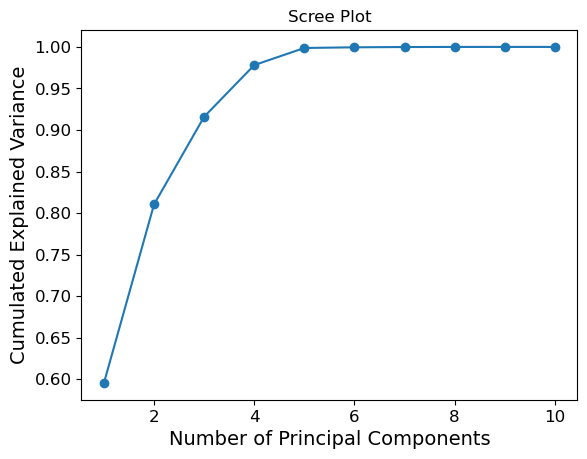

In [34]:
pca_prova = PCA(n_components=10)
pca_prova.fit(X_scaled)
# Explained variance
cumulative_variance_ratio = np.cumsum(pca_prova.explained_variance_ratio_)
# Scree plot
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulated Explained Variance')
plt.show()

In [35]:
table_pca = [['Provinces', '1° Component scores', '2° Component scores'],
    ['Monza', -4.647, -0.712],
    ['Lodi', -0.986, 1.687],
    ['Mantova', -0.091, 2.444],
    ['Sondrio', 5.284, -0.606],
    ['Lecco', 1.041, -0.512],
    ['Cremona', -0.906, 2.401],
    ['Milano', -3.846, -1.545],
    ['Varese', 0.089, -1.795],
    ['Como', 1.170, -1.619],
    ['Pavia', 0.902, 0.522],
    ['Brescia', 1.220, 0.741],
    ['Bergamo', 0.769, -1.006]]
print(tabulate(table_pca, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤═══════════════════════╤═══════════════════════╕
│ Provinces   │   1° Component scores │   2° Component scores │
╞═════════════╪═══════════════════════╪═══════════════════════╡
│ Monza       │                -4.647 │                -0.712 │
├─────────────┼───────────────────────┼───────────────────────┤
│ Lodi        │                -0.986 │                 1.687 │
├─────────────┼───────────────────────┼───────────────────────┤
│ Mantova     │                -0.091 │                 2.444 │
├─────────────┼───────────────────────┼───────────────────────┤
│ Sondrio     │                 5.284 │                -0.606 │
├─────────────┼───────────────────────┼───────────────────────┤
│ Lecco       │                 1.041 │                -0.512 │
├─────────────┼───────────────────────┼───────────────────────┤
│ Cremona     │                -0.906 │                 2.401 │
├─────────────┼───────────────────────┼───────────────────────┤
│ Milano      │                -3.846 │ 

In [36]:
kmeans_pca = KMeans(n_clusters=4, random_state=2)
kmeans_pca.fit(pca_data)

KMeans(n_clusters=4, random_state=2)

In [37]:
pred_pca = kmeans_pca.fit_predict(pca_data)

In [38]:
table1 = [['Clusters', 'Provinces'],
          ['0', 'Mantova, ' 'Lodi, ' 'Cremona'],
          ['1', 'Lecco, ' 'Varese, ' 'Como, ''Pavia, ''Brescia, ''Bergamo' ],
          ['2', 'Milano, ' 'Monza'],
          ['3', 'Sondrio']]
print(tabulate(table1, headers='firstrow', tablefmt='fancy_grid'))
#same clusters we found above

╒════════════╤══════════════════════════════════════════════╕
│   Clusters │ Provinces                                    │
╞════════════╪══════════════════════════════════════════════╡
│          0 │ Mantova, Lodi, Cremona                       │
├────────────┼──────────────────────────────────────────────┤
│          1 │ Lecco, Varese, Como, Pavia, Brescia, Bergamo │
├────────────┼──────────────────────────────────────────────┤
│          2 │ Milano, Monza                                │
├────────────┼──────────────────────────────────────────────┤
│          3 │ Sondrio                                      │
╘════════════╧══════════════════════════════════════════════╛


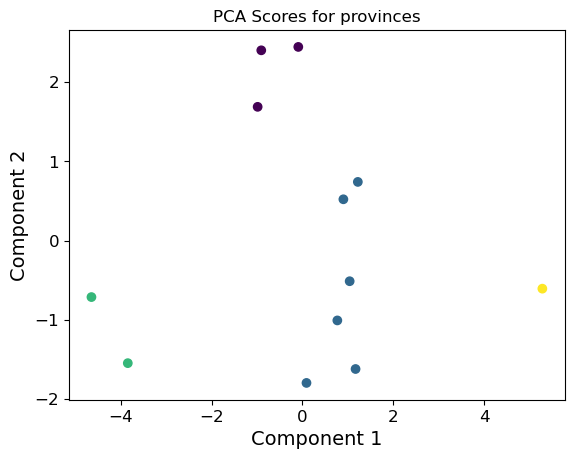

In [39]:
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_pca.labels_, cmap='viridis')
plt.title('PCA Scores for provinces')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [40]:
#linear combination loadings
table_loadings = [[' ', 'CO', 'NH3', 'NMVOC','NO2','NO','O3','PANS','PM10','PM2.5','SO2'],
                  ['1° Component',-0.405 , -0.131, -0.398, -0.313, -0.229, 0.187, -0.226, -0.368, -0.373, -0.387],
                  ['2° Component',-0.076  ,  0.595 , -0.144 ,  0.273 , -0.476, 0.062, -0.412,  0.262,  0.244, -0.128]]

print(tabulate(table_loadings, headers='firstrow', tablefmt='fancy_grid' ))

╒══════════════╤════════╤════════╤═════════╤════════╤════════╤═══════╤════════╤════════╤═════════╤════════╕
│              │     CO │    NH3 │   NMVOC │    NO2 │     NO │    O3 │   PANS │   PM10 │   PM2.5 │    SO2 │
╞══════════════╪════════╪════════╪═════════╪════════╪════════╪═══════╪════════╪════════╪═════════╪════════╡
│ 1° Component │ -0.405 │ -0.131 │  -0.398 │ -0.313 │ -0.229 │ 0.187 │ -0.226 │ -0.368 │  -0.373 │ -0.387 │
├──────────────┼────────┼────────┼─────────┼────────┼────────┼───────┼────────┼────────┼─────────┼────────┤
│ 2° Component │ -0.076 │  0.595 │  -0.144 │  0.273 │ -0.476 │ 0.062 │ -0.412 │  0.262 │   0.244 │ -0.128 │
╘══════════════╧════════╧════════╧═════════╧════════╧════════╧═══════╧════════╧════════╧═════════╧════════╛


**ANALYSIS 1° COMPONENT**   
General pollution level   
**ANALYSIS 2° COMPONENT**   
Seems to be affect in particular by 'NH3' (0.59), then also 'NO2', 'PM10' and 'PM2.5' have a positive effect, while 'NO' has a negative effect.

### SO WE OBTAINED THE SAME 4 CLUSTERS FOR EACH OF 3 METHODS.

In [41]:
data_tab = {
    'CO': [316.293441, 294.449610, 419.772512, 164.472891],
    'NH3': [22.726513, 6.541699, 8.816668, 1.109862],
    'NMVOC': [51.627203, 45.748921, 100.128512, 10.873919],
    'NO2': [28.162122, 15.538113, 35.249271, 2.300199],
    'NO': [6.877687, 14.200878, 30.647500, 5.394709],
    'O3': [79.205621, 80.416605, 75.929724, 77.098113],
    'PANS': [2.953328, 3.331819, 3.519475, 2.563919],
    'PM10': [28.425345, 21.513350, 29.469314, 9.605544],
    'PM2.5': [23.929783, 18.114873, 25.206603, 7.617891],
    'SO2': [1.694974, 1.517849, 3.333298, 0.278267]
}
labels_tab = [0, 1, 2, 3]
tab = pd.DataFrame(data_tab, index=labels_tab)
print(tabulate(tab, headers='keys', tablefmt='fancy_grid'))

╒════╤═════════╤══════════╤══════════╤═════════╤══════════╤═════════╤═════════╤══════════╤══════════╤══════════╕
│    │      CO │      NH3 │    NMVOC │     NO2 │       NO │      O3 │    PANS │     PM10 │    PM2.5 │      SO2 │
╞════╪═════════╪══════════╪══════════╪═════════╪══════════╪═════════╪═════════╪══════════╪══════════╪══════════╡
│  0 │ 316.293 │ 22.7265  │  51.6272 │ 28.1621 │  6.87769 │ 79.2056 │ 2.95333 │ 28.4253  │ 23.9298  │ 1.69497  │
├────┼─────────┼──────────┼──────────┼─────────┼──────────┼─────────┼─────────┼──────────┼──────────┼──────────┤
│  1 │ 294.45  │  6.5417  │  45.7489 │ 15.5381 │ 14.2009  │ 80.4166 │ 3.33182 │ 21.5133  │ 18.1149  │ 1.51785  │
├────┼─────────┼──────────┼──────────┼─────────┼──────────┼─────────┼─────────┼──────────┼──────────┼──────────┤
│  2 │ 419.773 │  8.81667 │ 100.129  │ 35.2493 │ 30.6475  │ 75.9297 │ 3.51947 │ 29.4693  │ 25.2066  │ 3.3333   │
├────┼─────────┼──────────┼──────────┼─────────┼──────────┼─────────┼─────────┼──────────┼──────

**CLUSTER VISUALIZATION**

In [42]:
df_ic = pd.read_csv(f'{DATA_PATH}/InfoComune.csv', encoding='latin-1')

In [43]:
df_ic = df_ic[df_ic['CodREG'] == 3]
df_ic.shape
df_ic['CodPROV'] = df_ic['CodPROV'].astype(str)

In [44]:
def assign_label(row):
    if row['CodPROV'] == '12' or row['CodPROV'] == '13' or row['CodPROV'] == '16' or row['CodPROV'] == '97' or row['CodPROV'] == '17' or row['CodPROV'] == '18':
        return 1
    elif row['CodPROV'] == '14':
        return 3
    elif row['CodPROV'] == '15' or row['CodPROV'] == '108':
        return 2
    elif row['CodPROV'] == '19' or row['CodPROV'] == '20' or row['CodPROV'] == '98':
        return 0
    else:
        return 'N/A'

In [45]:
df_ic['label'] = df_ic.apply(assign_label, axis=1)

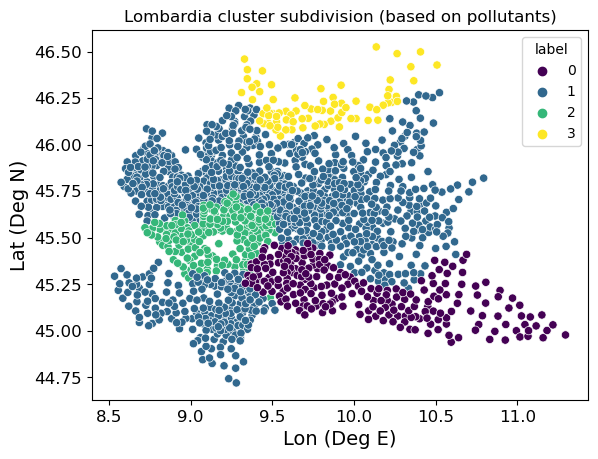

In [46]:
geoplot1 = sns.scatterplot(x="Lon (Deg E)", y="Lat (Deg N)", hue='label', data=df_ic, palette='viridis')
fig = geoplot1.get_figure()
plt.title('Lombardia cluster subdivision (based on pollutants)')
plt.show()

## 2nd Research Question

**How do K-means clustering and time series K-means clustering techniques differ in their ability to reveal similar patterns in time series data related to the AQI_1 variable, representing the daily average of three surveys?**

AQI is EPA’s index for reporting air quality.      
EPA establishes an AQI for **five major air pollutants** regulated by the Clean Air Act. Each of these pollutants has a national air quality standard set by EPA to protect public health:   
- ground-level ozone (O3)
- particle pollution (also known as particulate matter, including PM2.5 and PM10)
- carbon monoxide (CO)
- sulfur dioxide (SO2)
- nitrogen dioxide (NO2)   

There are **6 levels of concern:**

- Good (0-50)
- Moderate (51-100)
- Unhealthy for Sensitive Groups (101-150)
- Unhealthy (151-200)
- Very Unhealthy (201-300)
- Hazardous (301-350)


In [47]:
df = pd.read_csv(f'{RESULTS_PATH}/combined_df.csv', header=[0,1])
df.columns = df.columns.droplevel(1)
df['DATA']=pd.to_datetime(df['DATA'])
df['AQI_1'] = df['AQI_1'].apply(pd.to_numeric, errors='coerce')

In [48]:
print(df.iloc[:,13][df['DATA']=='2020-2-29'])
#here we're seeing the NaN for all the provinces in the 29 february 2020

789     NaN
2097    NaN
3405    NaN
4713    NaN
6021    NaN
7329    NaN
8637    NaN
9945    NaN
11253   NaN
12561   NaN
13869   NaN
15177   NaN
Name: AQI_1, dtype: float64


In [49]:
rows_to_drop = df[df['DATA'] == '2020-02-29'].index
#Delete the 2020-02-29 row
df.drop(rows_to_drop, inplace=True)

In [50]:
new_X = df[['DATA', 'PROV', 'AQI_1']].copy()

In [51]:
print(new_X[new_X['DATA']=='2020-12-29'])
print(new_X[new_X['DATA']=='2020-12-30'])
print(new_X[new_X['DATA']=='2020-12-31'])
#for 29, 30, 31 december we have NaN

            DATA  PROV  AQI_1
1093  2020-12-29   138    NaN
2401  2020-12-29   148    NaN
3709  2020-12-29    77    NaN
5017  2020-12-29   133    NaN
6325  2020-12-29   243    NaN
7633  2020-12-29   205    NaN
8941  2020-12-29   186    NaN
10249 2020-12-29   113    NaN
11557 2020-12-29    64    NaN
12865 2020-12-29    84    NaN
14173 2020-12-29    60    NaN
15481 2020-12-29    55    NaN
            DATA  PROV  AQI_1
1094  2020-12-30   138    NaN
2402  2020-12-30   148    NaN
3710  2020-12-30    77    NaN
5018  2020-12-30   133    NaN
6326  2020-12-30   243    NaN
7634  2020-12-30   205    NaN
8942  2020-12-30   186    NaN
10250 2020-12-30   113    NaN
11558 2020-12-30    64    NaN
12866 2020-12-30    84    NaN
14174 2020-12-30    60    NaN
15482 2020-12-30    55    NaN
            DATA  PROV  AQI_1
1095  2020-12-31   138    NaN
2403  2020-12-31   148    NaN
3711  2020-12-31    77    NaN
5019  2020-12-31   133    NaN
6327  2020-12-31   243    NaN
7635  2020-12-31   205    NaN
8943  2020

In [52]:
## imputation for these dates
province_list = new_X['PROV'].unique() 
for provincia in province_list:
    missing_data = new_X[(new_X['DATA'].dt.year == 2020) & (new_X['DATA'].dt.month == 12) & (new_X['DATA'].dt.day.isin([29,30,31])) & (new_X['PROV']==provincia) & new_X['AQI_1'].isnull()]   
    for index, row in missing_data.iterrows():
        day = row['DATA'].day
        month = row['DATA'].month
        # Compute mean of the same days for the two previous years
        average_2019 = new_X[(new_X['DATA'].dt.year == 2019) & (new_X['DATA'].dt.month == month) & (new_X['DATA'].dt.day == day) & (new_X['PROV']==provincia)]['AQI_1'].mean()
        average_2018 = new_X[(new_X['DATA'].dt.year == 2018) & (new_X['DATA'].dt.month == month) & (new_X['DATA'].dt.day == day) & (new_X['PROV']==provincia)]['AQI_1'].mean()
        # Compute mean of the two means
        imputed_value = (average_2019 + average_2018) / 2
        # Impute the value
        new_X.at[index, 'AQI_1'] = imputed_value 

In [66]:
print(new_X[new_X['DATA']=='2020-12-29'])
print(new_X[new_X['DATA']=='2020-12-30'])
print(new_X[new_X['DATA']=='2020-12-31'])
## now the NaN have been imputated

            DATA  PROV   AQI_1
1093  2020-12-29   138  34.890
2401  2020-12-29   148  27.920
3709  2020-12-29    77  25.175
5017  2020-12-29   133  46.470
6325  2020-12-29   243  30.300
7633  2020-12-29   205  30.320
8941  2020-12-29   186  39.790
10249 2020-12-29   113  37.780
11557 2020-12-29    64  35.995
12865 2020-12-29    84  26.685
14173 2020-12-29    60  40.015
15481 2020-12-29    55  42.860
            DATA  PROV   AQI_1
1094  2020-12-30   138  27.655
2402  2020-12-30   148  27.590
3710  2020-12-30    77  28.695
5018  2020-12-30   133  30.935
6326  2020-12-30   243  30.780
7634  2020-12-30   205  33.105
8942  2020-12-30   186  29.235
10250 2020-12-30   113  35.640
11558 2020-12-30    64  35.565
12866 2020-12-30    84  28.490
14174 2020-12-30    60  31.050
15482 2020-12-30    55  28.180
            DATA  PROV   AQI_1
1095  2020-12-31   138  28.575
2403  2020-12-31   148  27.430
3711  2020-12-31    77  29.185
5019  2020-12-31   133  37.555
6327  2020-12-31   243  29.940
7635  20

In [53]:
# modify the province identifier with the real province name
mappa_province = {
    55: 'Monza', #108
    60: 'Lodi', #098
    64: 'Mantova', #020
    77: 'Sondrio', #014
    84: 'Lecco', #097
    113: 'Cremona', #019
    133: 'Milano', #015
    138: 'Varese', #012
    148: 'Como', #013
    186: 'Pavia', #018
    205: 'Brescia', #017
    243: 'Bergamo',  #016
}
new_X['PROV'] = new_X['PROV'].map(mappa_province)

### DESCRIPTIVE ANALYSIS - PIE CHARTS

In [54]:
# Define a function to assign the category evaluating the interval in which the AQI value falls.
# Those intervals are defined by U.S. Environmental Protection Agency (EPA).
def assign_color(aqi):
    if 0 <= aqi <= 50:
        return 'Good'
    elif 50 < aqi <= 100:
        return 'Moderate'
    elif 100 < aqi <= 150:
        return 'Unhealthy for sensitive groups'
    elif 150 < aqi <= 200:
        return 'Unhealthy'
    else:
        return 'Dangerous'
new_X['category'] = new_X['AQI_1'].apply(assign_color)

In [55]:
new_X['category'].value_counts()

category
Good                              14875
Moderate                            805
Unhealthy for sensitive groups        4
Name: count, dtype: int64

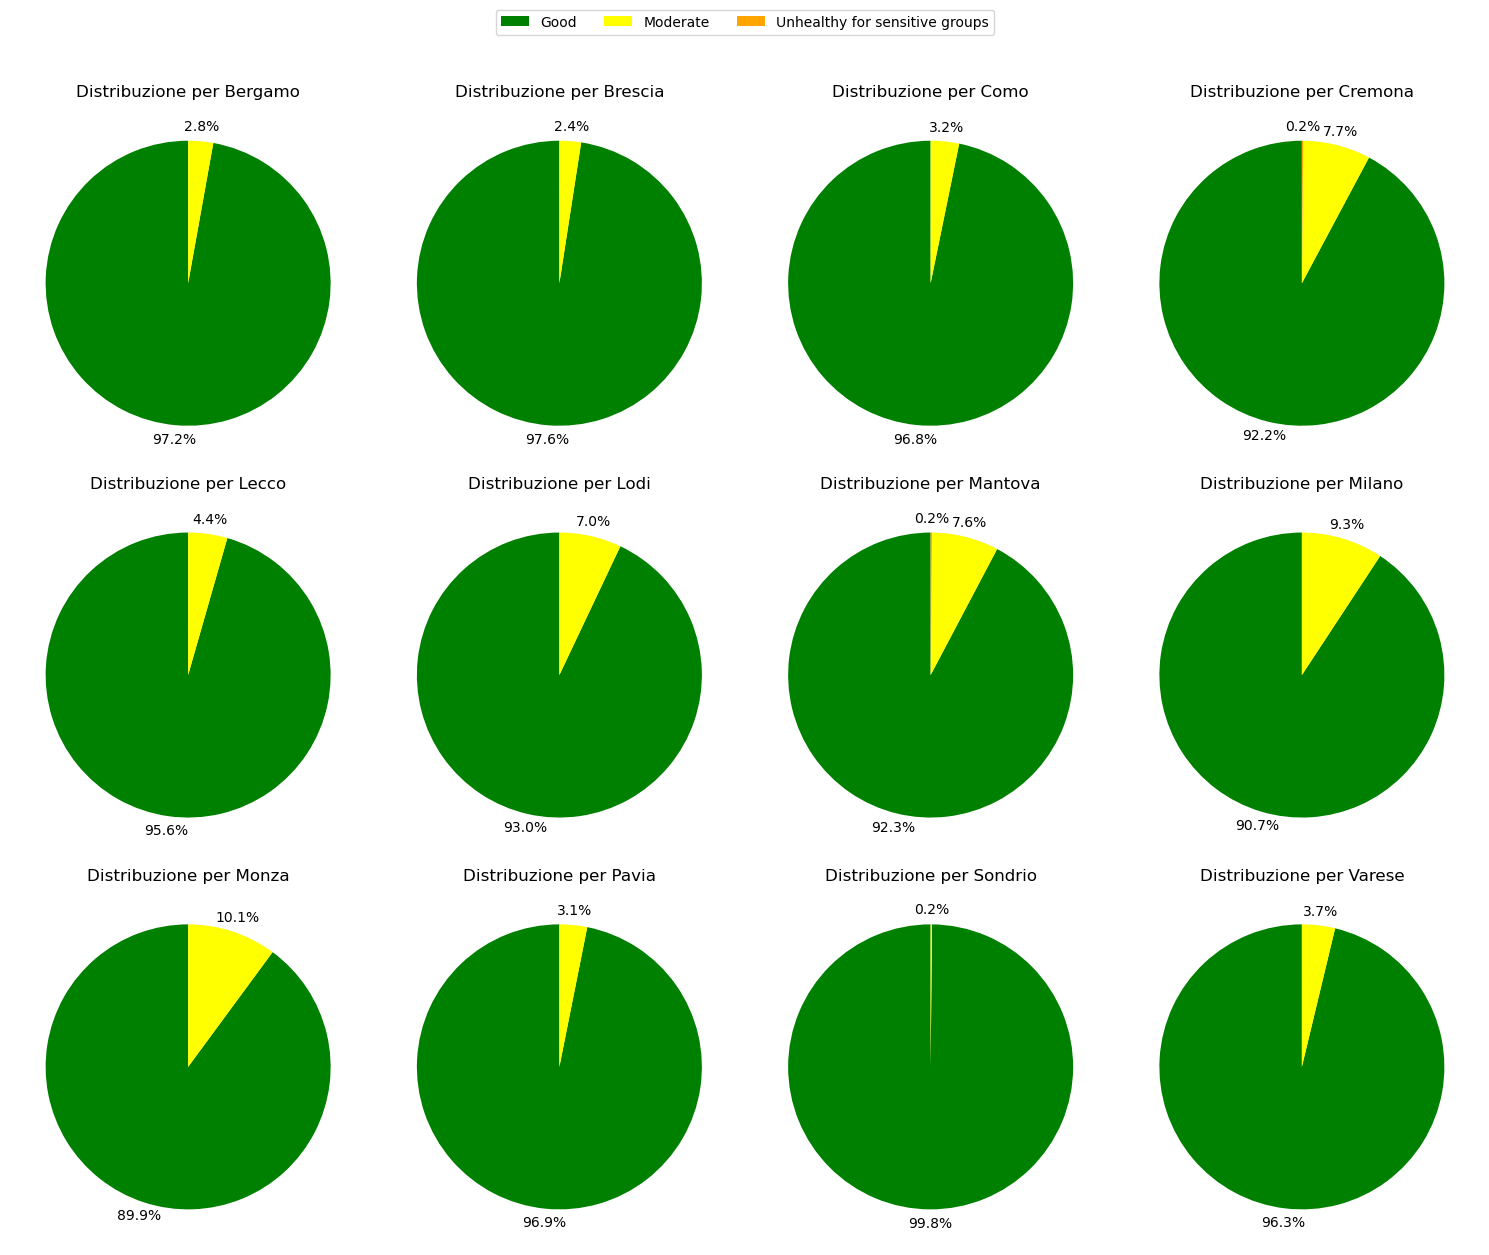

In [56]:
province_categories = new_X.groupby(['PROV', 'category']).size().unstack()
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
# Create a pie chart for each province
for i, (province, ax) in enumerate(zip(province_categories.index, axes.flatten())):
    province_data = province_categories.loc[province]
    # Delete the categories with 0.0 percentage
    province_data_nonzero = province_data[province_data != 0]
    province_data_nonzero.plot(kind='pie', autopct=lambda p: f'{p:.1f}%' if p > 0 else '', startangle=90, pctdistance = 1.1, labels=None, colors=['green', 'yellow', 'orange', 'red', 'purple'], ax=ax)
    ax.set_title(f'Distribuzione per {province}')
    ax.set_ylabel('')
fig.legend(province_data_nonzero.index, loc="upper center", bbox_to_anchor=(0.5, 1.05), 
           ncol=len(province_data_nonzero), bbox_transform=plt.gcf().transFigure, borderaxespad=0.)
# Fix the layout to avoid figures overlap
plt.tight_layout()
plt.show()

In [57]:
pivoted_X = new_X.pivot(index='DATA', columns='PROV', values='AQI_1')
pivoted_X.describe()

PROV,Bergamo,Brescia,Como,Cremona,Lecco,Lodi,Mantova,Milano,Monza,Pavia,Sondrio,Varese
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,31.950321,31.692303,32.038424,33.386301,32.319357,33.400497,33.074120,33.870681,34.496672,32.293236,28.232888,31.355440
std,8.851205,8.532828,9.219959,11.712337,9.624716,11.247129,11.531345,12.106344,12.585839,9.316378,7.054593,9.583487
min,12.530000,12.600000,9.910000,10.170000,11.540000,9.900000,8.430000,11.470000,11.730000,10.340000,11.700000,9.930000
25%,25.430000,25.640000,25.335000,25.880000,25.020000,25.890000,25.710000,25.660000,25.565000,26.065000,23.455000,24.640000
50%,31.240000,30.980000,31.260000,31.760000,31.350000,32.180000,31.690000,32.170000,32.470000,32.090000,27.980000,30.720000
75%,37.680000,37.265000,37.880000,38.180000,38.470000,38.815000,38.105000,39.475000,40.510000,37.970000,33.160000,37.130000
max,85.280000,76.330000,85.710000,102.360000,85.600000,95.420000,107.730000,97.310000,99.280000,90.090000,70.190000,86.280000


### 2.1 - CLASSIC KMEANS

In [58]:
new_X2 = new_X[['DATA','PROV', 'AQI_1']].copy()
wide_df = new_X2.groupby(['DATA','PROV']).sum().unstack().T.reset_index(level=0,drop=True)
wide_df

DATA,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08,2018-01-09,2018-01-10,...,2021-07-22,2021-07-23,2021-07-24,2021-07-25,2021-07-26,2021-07-27,2021-07-28,2021-07-29,2021-07-30,2021-07-31
PROV,,,,,,,,,,,,,,,,,,,,,
Bergamo,23.40,24.29,24.51,23.29,24.98,22.88,22.50,21.94,23.68,25.00,...,43.15,45.56,44.00,35.72,33.32,28.13,27.67,35.03,41.00,37.22
Brescia,22.66,22.49,22.40,21.76,24.70,22.16,21.71,24.70,24.55,24.74,...,41.42,42.84,43.06,37.08,31.25,27.96,27.34,33.15,39.14,36.76
Como,23.38,24.11,24.24,20.52,23.12,21.65,19.28,18.36,21.32,23.70,...,47.52,49.59,44.19,34.99,36.16,28.72,26.19,33.12,39.12,36.03
Cremona,23.68,16.96,14.66,16.15,29.97,32.07,23.84,22.97,23.33,24.17,...,38.03,45.31,38.26,37.71,33.74,28.80,29.97,33.08,36.35,36.11
Lecco,22.92,23.84,24.86,22.01,22.15,22.26,20.17,19.12,23.23,23.78,...,47.89,49.76,46.49,35.84,35.91,29.10,27.31,35.29,42.70,37.83
Lodi,24.84,17.73,15.09,15.03,31.12,33.53,24.25,20.45,19.69,22.95,...,38.95,45.85,38.15,37.48,35.05,30.06,32.47,35.82,35.65,38.25
Mantova,21.03,16.29,16.93,17.78,29.38,28.28,21.99,23.95,27.18,26.44,...,37.73,43.55,39.73,40.13,34.97,29.00,31.25,33.70,37.41,38.73
Milano,30.22,17.11,15.76,17.09,38.87,36.57,25.97,19.38,18.30,28.57,...,41.22,45.61,41.15,35.09,35.26,29.39,30.66,31.25,31.37,33.71
Monza,31.41,16.17,15.77,17.93,37.30,33.83,25.89,18.48,19.56,30.71,...,44.85,47.86,45.58,36.96,35.85,28.48,29.05,34.11,37.58,36.00


In [59]:
#Time series standardization
X2_normalized = StandardScaler().fit_transform(wide_df)

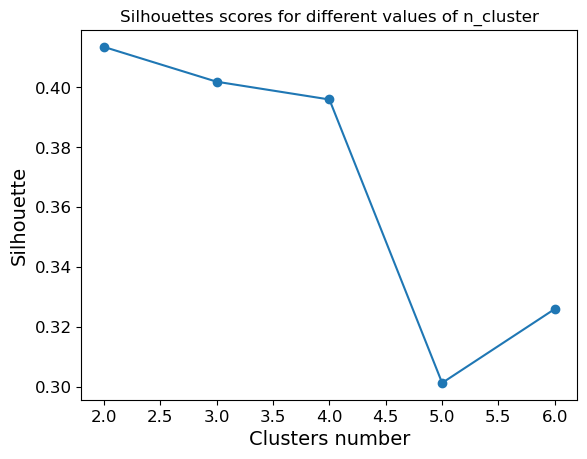

In [60]:
## silhouette scores 
silhouette_scores = []
n_clusters_range = range(2, 7)

for n_cluster in n_clusters_range:   
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)     
    kmeans.fit(X2_normalized)
    silhouette_coefficient = silhouette_score(wide_df, kmeans.labels_)
    silhouette_scores.append(silhouette_coefficient)

# Silhouette coefficients on clusters number 
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.xlabel('Clusters number')
plt.ylabel('Silhouette')
plt.title('Silhouettes scores for different values of n_cluster')
plt.show()

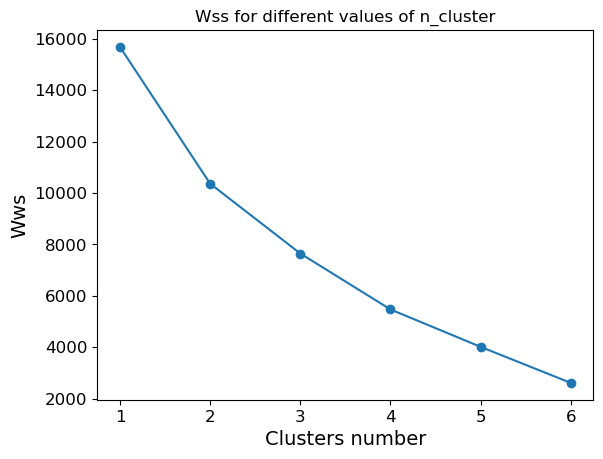

In [61]:
## WSS scores, within cluster squared sum
wss = []
n_clusters_range = range(1, 7)
for n_cluster in n_clusters_range:
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    kmeans.fit(X2_normalized)
    wss.append(kmeans.inertia_)

# Plot del valore WSS al variare del numero di cluster
plt.plot(n_clusters_range, wss, marker='o')
plt.xlabel('Clusters number')
plt.ylabel('Wws')
plt.title('Wss for different values of n_cluster')
plt.show()

Looking at those two measures we choose 2 clusters even if it's not well defined.

In [62]:
kmeans2 = KMeans(n_clusters=2, random_state=0)     
kmeans2.fit(X2_normalized)    

KMeans(n_clusters=2, random_state=0)

In [63]:
from tabulate import tabulate
table1 = [['Clusters', 'Provinces'],
          ['0', 'Mantova, ' 'Lodi, ' 'Cremona,' ' Milano, ' 'Monza,'' Pavia '],
          ['1', 'Lecco, ' 'Varese, ' 'Como, ''Brescia, ''Bergamo,'' Sondrio' ]]
print(tabulate(table1, headers='firstrow', tablefmt='fancy_grid'))

╒════════════╤════════════════════════════════════════════════╕
│   Clusters │ Provinces                                      │
╞════════════╪════════════════════════════════════════════════╡
│          0 │ Mantova, Lodi, Cremona, Milano, Monza, Pavia   │
├────────────┼────────────────────────────────────────────────┤
│          1 │ Lecco, Varese, Como, Brescia, Bergamo, Sondrio │
╘════════════╧════════════════════════════════════════════════╛


### 2.2 - TIME SERIES KMEANS

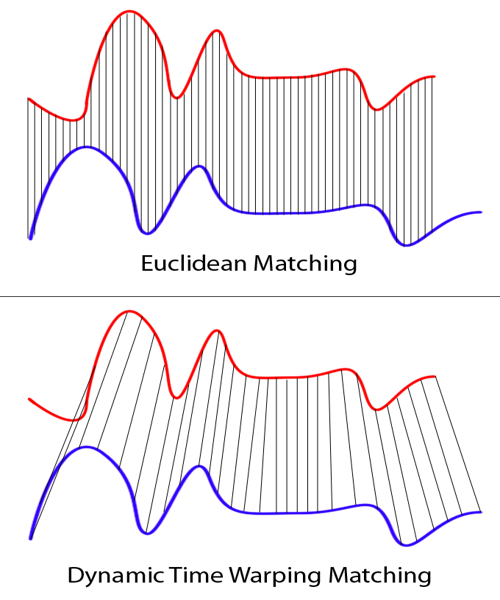

In [65]:
from PIL import Image 
from IPython.display import display
image_path = f'{IMAGES_PATH}/Euclidean_vs_DTW.jpg'
img = Image.open(image_path) 
new_size = (500, 600) 
resized_img = img.resize(new_size)
display(resized_img)

In [66]:
# Time series standardization with TimeSeriesScalerMeanVariance
X_normalized = TimeSeriesScalerMeanVariance().fit_transform(wide_df)

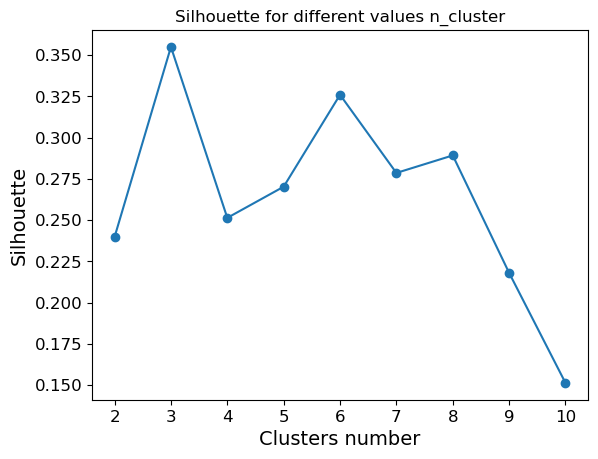

In [67]:
silhouette_scores = []
n_clusters_range = range(2, 11)

for n_cluster in n_clusters_range:   
    kmeans = TimeSeriesKMeans(n_clusters=n_cluster, random_state=0, metric='dtw')     
    kmeans.fit(X_normalized)
    silhouette_coefficient = silhouette_score(wide_df, kmeans.labels_)
    silhouette_scores.append(silhouette_coefficient)

plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.xlabel('Clusters number')
plt.ylabel('Silhouette')
plt.title('Silhouette for different values n_cluster')
plt.show()
# The silhouette score evaluates the goodness of the split of the clusters
# Is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation)

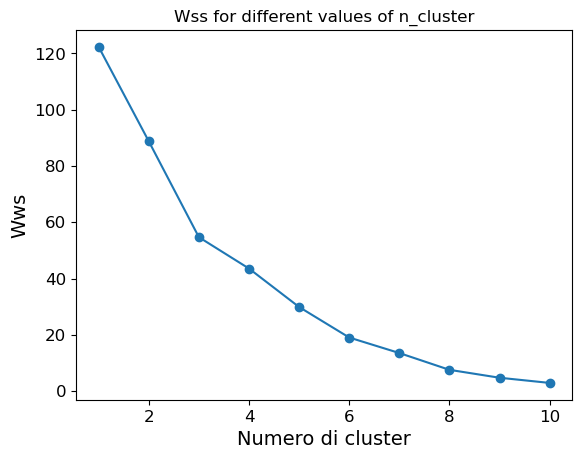

In [68]:
wss = []
n_clusters_range = range(1, 11)
for n_cluster in n_clusters_range:
    kmeans = TimeSeriesKMeans(n_clusters=n_cluster, random_state=0, metric = 'dtw')
    kmeans.fit(X_normalized)
    wss.append(kmeans.inertia_)

plt.plot(n_clusters_range, wss, marker='o')
plt.xlabel('Numero di cluster')
plt.ylabel('Wws')
plt.title('Wss for different values of n_cluster')
plt.show()
#Within cluster sum of squares, within variance.

**In this case silhouette and wss confirm us the same thing: 3 clusters.**

In [69]:
kmeans = TimeSeriesKMeans(n_clusters=3, random_state=0, metric='dtw')     
kmeans.fit(X_normalized)  

TimeSeriesKMeans(metric='dtw', random_state=0)

In [70]:
from tabulate import tabulate
table1 = [['Clusters', 'Provinces'],
          ['0', 'Mantova, ' 'Lodi, ' 'Cremona,' ' Milano, ' 'Monza,'' Pavia '],
          ['1', 'Sondrio'],
          ['2', 'Lecco, ' 'Varese, ' 'Como, ''Brescia, ''Bergamo' ]]
print(tabulate(table1, headers='firstrow', tablefmt='fancy_grid'))

╒════════════╤══════════════════════════════════════════════╕
│   Clusters │ Provinces                                    │
╞════════════╪══════════════════════════════════════════════╡
│          0 │ Mantova, Lodi, Cremona, Milano, Monza, Pavia │
├────────────┼──────────────────────────────────────────────┤
│          1 │ Sondrio                                      │
├────────────┼──────────────────────────────────────────────┤
│          2 │ Lecco, Varese, Como, Brescia, Bergamo        │
╘════════════╧══════════════════════════════════════════════╛


In [71]:
## settings for graphs below
import matplotlib.patches as mpatches
from collections import OrderedDict
# Mappings between provinces and clusters
province_cluster_mapping = {
    'Cremona': 0, 'Lodi': 0, 'Mantova': 0, 'Milano': 0, 'Monza': 0, 'Pavia': 0,
    'Como': 1, 'Lecco': 1, 'Varese': 1,  'Bergamo': 1, 'Brescia': 1,
    'Sondrio': 2,
}
colors = ['red', 'green', 'blue']
# Create a dictionary with the colors and provinces
province_colors = {}
for province in pivoted_X.columns:
    cluster = province_cluster_mapping.get(province, -1)
    color = colors[cluster]
    province_colors[province] = mpatches.Patch(color=color)
# Sort the dictionary by colors and provinces
sorted_province_colors = OrderedDict(sorted(province_colors.items(), key=lambda x: province_cluster_mapping.get(x[0], -1)))

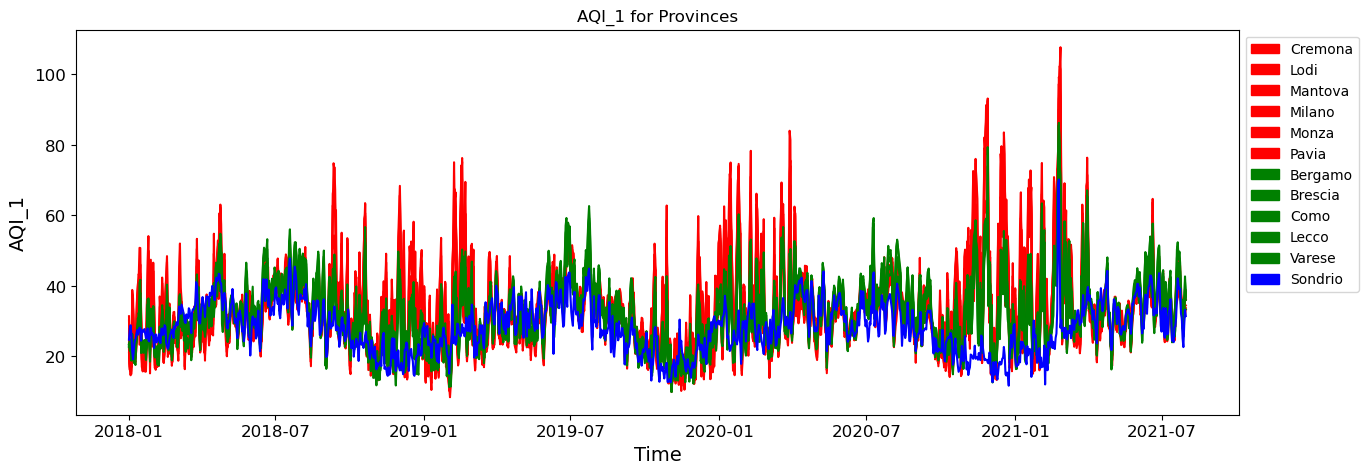

In [72]:
# Plot a line for each provinces with colors based on clusters
plt.figure(figsize=(15, 5))
for province, color_patch in sorted_province_colors.items():
    plt.plot(pivoted_X.index, pivoted_X[province], label=province, color=color_patch.get_facecolor())
    
plt.title("AQI_1 for Provinces")
plt.xlabel("Time")
plt.ylabel("AQI_1")

# sorted legend
plt.legend(handles=list(sorted_province_colors.values()), labels=list(sorted_province_colors.keys()),
           loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

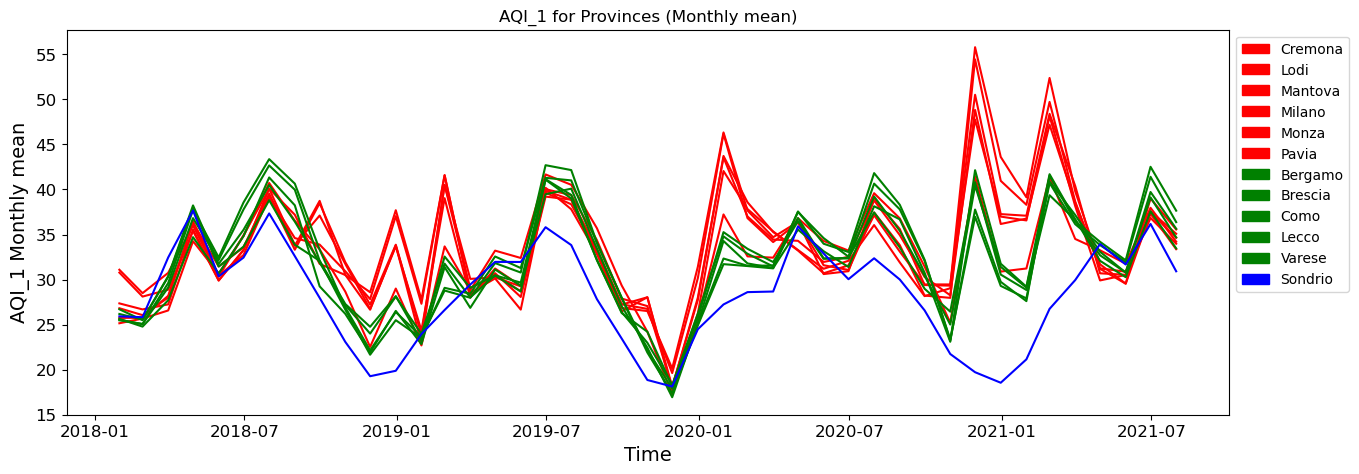

In [73]:
# monthly mean
plt.figure(figsize=(15, 5))
for province, color_patch in sorted_province_colors.items():
    #using resample to compute monthly mean
    monthly_mean = pivoted_X[province].resample('1M').mean()
    plt.plot(monthly_mean.index, monthly_mean, label=province, color=color_patch.get_facecolor())

plt.title("AQI_1 for Provinces (Monthly mean)")
plt.xlabel("Time")
plt.ylabel("AQI_1 Monthly mean")

plt.legend(handles=list(sorted_province_colors.values()), labels=list(sorted_province_colors.keys()), loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

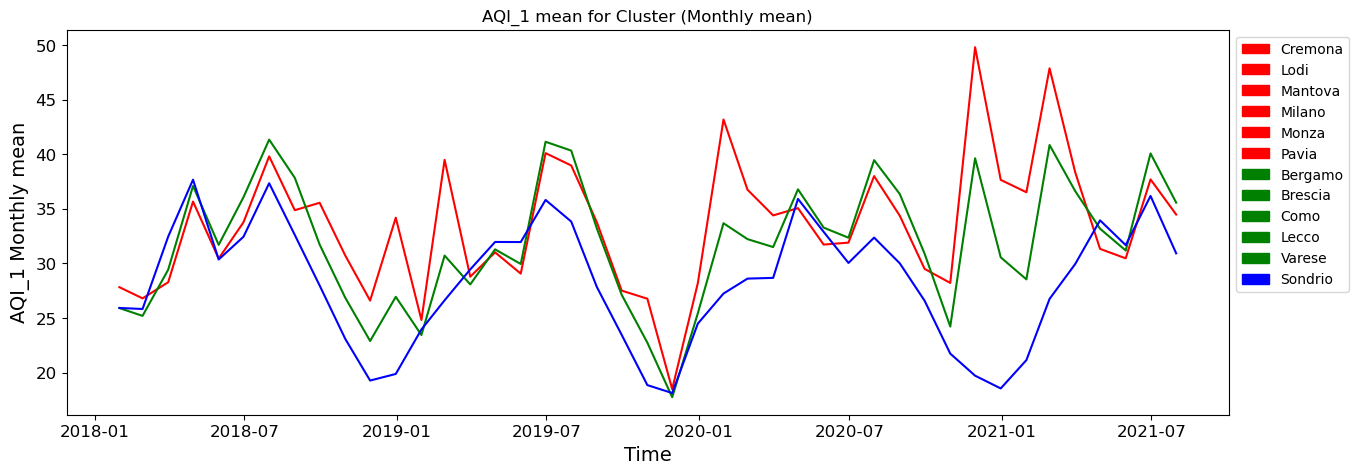

In [74]:
cluster_means = pivoted_X.groupby(lambda x: province_cluster_mapping[x], axis=1).mean()
colors = ['red', 'green', 'blue']
plt.figure(figsize=(15, 5))
for i, cluster_mean in enumerate(cluster_means.columns):
    monthly_mean = cluster_means[cluster_mean].resample('1M').mean()
    plt.plot(monthly_mean.index, monthly_mean, label=f'Cluster {i}', color=colors[i])
plt.title("AQI_1 mean for Cluster (Monthly mean)")
plt.xlabel("Time")
plt.ylabel("AQI_1 Monthly mean")
plt.legend(handles=list(sorted_province_colors.values()), labels=list(sorted_province_colors.keys()), loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

**CLUSTER VISUALIZATION**

In [75]:
def assign_label(row):
    if row['CodPROV'] == '12' or row['CodPROV'] == '13' or row['CodPROV'] == '16' or row['CodPROV'] == '97' or row['CodPROV'] == '17':
        return 2
    elif row['CodPROV'] == '14':
        return 1
    elif row['CodPROV'] == '19' or row['CodPROV'] == '20' or row['CodPROV'] == '98' or row['CodPROV'] == '18' or row['CodPROV'] == '108' or row['CodPROV'] == '15':
        return 0
    else:
        return 'N/A' 

In [76]:
df_ic['label2'] = df_ic.apply(assign_label, axis=1)

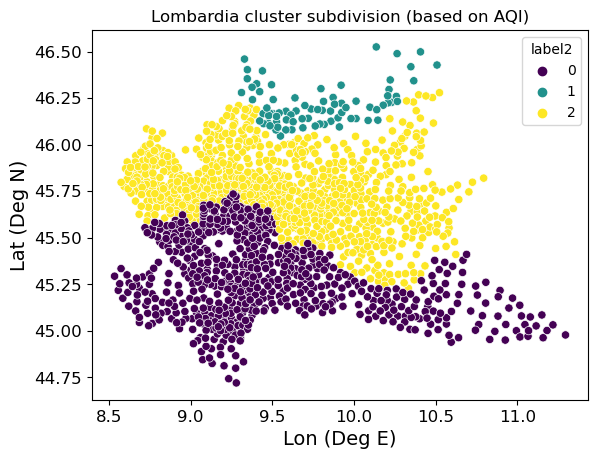

In [77]:
geoplot2 = sns.scatterplot(x="Lon (Deg E)", y="Lat (Deg N)", hue='label2', data=df_ic, palette='viridis')
fig = geoplot2.get_figure()
fig.savefig(fname=f'{IMAGES_PATH}/Geoplot_RQ2.png')
plt.title('Lombardia cluster subdivision (based on AQI)')
plt.show()